In [1]:
import tensorflow as tf
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib nbagg

In [2]:
ep = xr.open_dataset('../../data/analyses/ERA-ep-SH.nc')
ep['time'] = ep.time - pd.Timedelta('1h')
ep = ep.sel(lat=slice(-55,None)).resample('D', 'time', how='sum')
p_min_e = ep['tp'] + ep['e']

In [263]:
y = p_min_e.isel(lon=128, lat=32).to_dataframe('y')['y']
t = y.index.values.astype('datetime64[D]')
yr = y.resample('A').mean() * 1000 
tr = yr.index.values.astype('datetime64[D]')

[linear regression example](https://stackoverflow.com/questions/43170017/linear-regression-with-tensorflow)

### least squares

In [12]:
def lstsq(features, labels):
    gr = tf.Graph()
    with gr.as_default():
        x = tf.placeholder(tf.float64)
        targ = tf.placeholder(tf.float64)
        X = tf.stack((tf.ones_like(x), x), axis=1)
        lsq = tf.matrix_solve_ls(X, tf.reshape(targ, (-1, 1))) # tf crashes the kernel if shapes passed are wrong!!!
    with tf.Session(graph=gr) as s:
        return s.run(lsq, {x: features.astype(float), targ: labels})

In [302]:
a, b = lstsq(t, y)
p1 = a + b * tr.astype(float)

## gradient descent

### by hand

In [290]:
def grdesc(features, labels, learn, steps):
    gr = tf.Graph()
    with gr.as_default():
        x = tf.placeholder(tf.float64)
        targ = tf.placeholder(tf.float64)
        a = tf.Variable(tf.random_normal([1], dtype=tf.float64), dtype=tf.float64)
        b = tf.Variable(tf.random_normal([1], dtype=tf.float64), dtype=tf.float64)
        y = a + b * x
        loss = tf.losses.mean_squared_error(targ, y)
        opt = tf.train.GradientDescentOptimizer(learn).minimize(loss)
        #step = tf.train.get_global_step()
        #train = tf.group(opt.minimize(loss), tf.assign_add(step, 1))
    with tf.Session(graph=gr) as s:
        tf.global_variables_initializer().run(session=s)
        for i in range(steps):
            r = s.run([opt, loss], {x: features, targ: labels})
            if i % 100 == 0:
                print(i, r)
        print(i, r)
        return s.run([a, b])

Gradient descent is sensitive to the learning rate (*learn* in function above, 0.1). It also only works if the data is properly normalized. 

In [304]:
ts = t.astype(float)
tstd = ts.std()
ts = ts / tstd
ystd = y.std()
a, b = grdesc(ts, y/ystd, 1e-1, 1000)
p2 = (a + b * tr.astype(float) / tstd) * ystd

0 [None, 13.986468]
100 [None, 1.0010877]
200 [None, 0.99961352]
300 [None, 0.99960119]
400 [None, 0.9996013]
500 [None, 0.99960142]
600 [None, 0.99960154]
700 [None, 0.99960148]
800 [None, 0.99960148]
900 [None, 0.99960148]
999 [None, 0.99960148]


### with estimator framework

In [311]:
inp = tf.estimator.inputs.numpy_input_fn({'x': ts}, y.values.astype('float64') / ystd,
                                         shuffle=True, num_epochs=None)
out = tf.estimator.inputs.numpy_input_fn({'x': tr.astype('float64') / tstd}, shuffle=False, num_epochs=1)
est = tf.estimator.LinearRegressor(feature_columns=[tf.feature_column.numeric_column('x', shape=(1,))])

In [325]:
est.train(inp, steps=2000)
p3 = np.array([k['predictions'] for k in est.predict(out)]) * ystd

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tmpp9rw7dbq/model.ckpt-3000
INFO:tensorflow:Saving checkpoints for 3001 into /tmp/tmpp9rw7dbq/model.ckpt.
INFO:tensorflow:loss = 115.53, step = 3001
INFO:tensorflow:global_step/sec: 1572.29
INFO:tensorflow:loss = 61.3848, step = 3101 (0.065 sec)
INFO:tensorflow:global_step/sec: 1182.32
INFO:tensorflow:loss = 58.1461, step = 3201 (0.085 sec)
INFO:tensorflow:global_step/sec: 1500.62
INFO:tensorflow:loss = 148.072, step = 3301 (0.067 sec)
INFO:tensorflow:global_step/sec: 1046.14
INFO:tensorflow:loss = 180.961, step = 3401 (0.095 sec)
INFO:tensorflow:global_step/sec: 1397.41
INFO:tensorflow:loss = 73.5488, step = 3501 (0.071 sec)
INFO:tensorflow:global_step/sec: 1340.19
INFO:tensorflow:loss = 147.906, step = 3601 (0.075 sec)
INFO:tensorflow:global_step/sec: 1230.25
INFO:tensorflow:loss = 99.3348, step = 3701 (0.082 sec)
INFO:tensorflow:global_step/sec: 1362.62
INFO:tensorflow:loss = 80.8355, step = 3

<IPython.core.display.Javascript object>


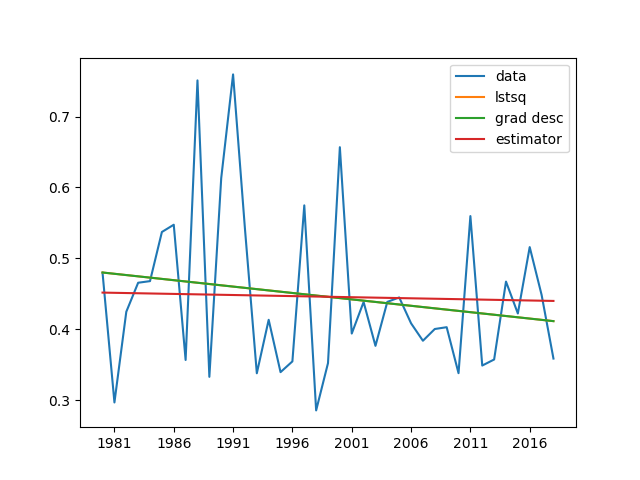

In [326]:
plt.figure()
plt.plot(yr, label='data')
plt.plot(tr, p1*1000, label='lstsq')
plt.plot(tr, p2*1000, label='grad desc')
plt.plot(tr, p3*1000, label='estimator')
plt.legend()